In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from glob import glob
from multiprocessing import Pool

import librosa
import librosa.display
from scipy.io import wavfile as wav

import IPython.display as ipd
from IPython.core.display import display

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, TimeDistributed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#data ingestion
def fetch_data(data):
    crema_directory_list = os.listdir(data)
    
    audio_path = []
    audio_emotion = []
    for path in crema_directory_list:
        emotion = path.split('_')[2]
        audio_emotion.append(emotion)
        audio_path.append(data + path)

    audio_emotion_df = pd.DataFrame(audio_emotion,columns = ['target_emotion'])
    audio_emotion_df = audio_emotion_df.replace({'ANG':'angry', 'SAD':'sad','DIS':'disgust','HAP':'happy','FEA':'fear','NEU':'neutral'})

    audio_path = pd.DataFrame(audio_path, columns=['path'])

    crema_df = pd.concat([audio_path, audio_emotion_df], axis = 1)
    return crema_df

In [4]:
crema_path = '/content/drive/MyDrive/AudioWAV/'
crema_df = fetch_data(crema_path)
crema_df.head()

,path,target_emotion
0,/content/drive/MyDrive/AudioWAV/1080_IEO_DIS_L...,disgust
1,/content/drive/MyDrive/AudioWAV/1080_IOM_DIS_X...,disgust
2,/content/drive/MyDrive/AudioWAV/1080_IEO_SAD_M...,sad
3,/content/drive/MyDrive/AudioWAV/1080_IOM_FEA_X...,fear
4,/content/drive/MyDrive/AudioWAV/1080_IOM_NEU_X...,neutral


In [5]:
REQUIRED_EMOTIONS = ['angry', 'neutral', 'happy']
crema_df = crema_df[crema_df['target_emotion'].isin(REQUIRED_EMOTIONS)]

In [6]:
print(crema_df.target_emotion.dtype)
crema_df.target_emotion = pd.Categorical(crema_df.target_emotion)
print(crema_df.target_emotion.unique())

object
['neutral', 'angry', 'happy']
Categories (3, object): ['angry', 'happy', 'neutral']


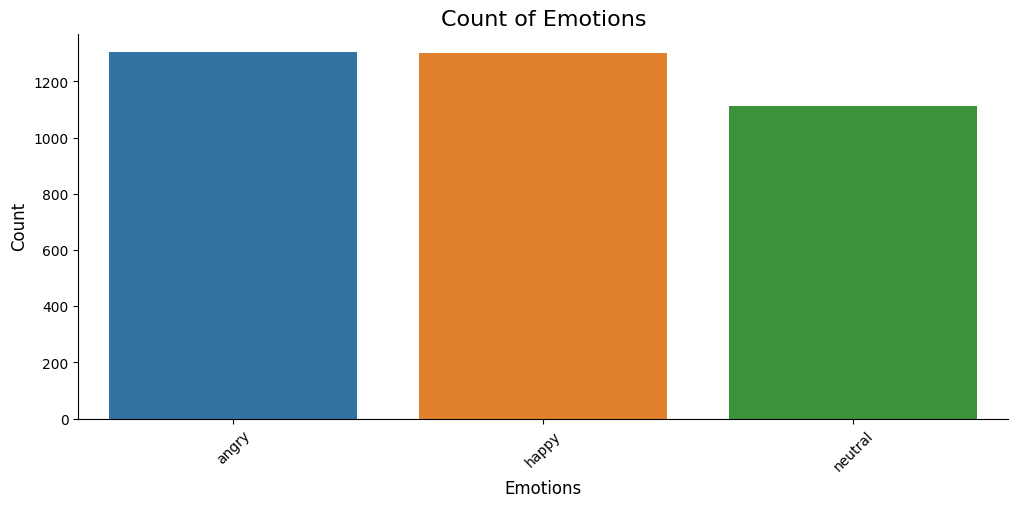

In [7]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(x=crema_df.target_emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, origin, e):
    #plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} audio with {} emotion'.format(origin, e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    #plt.figure(figsize=(12, 3))
    plt.title('MFCC for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')   
    plt.colorbar()
    plt.show()

def play_audio(path, sr):
    print('Audio file:',path.split('/')[5])
    display(ipd.Audio(path, rate=sr))

def create_melspectrogram(data, sr, e):
    #plt.figure(figsize=(7, 5))
    m_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
    m_spectrogram = librosa.power_to_db(m_spectrogram)
    librosa.display.specshow(m_spectrogram, y_axis='mel', fmax=8000, x_axis='time')
    plt.title('MelSpectrogram for audio with {} emotion'.format(e), size=15)
    plt.colorbar(format='%+2.0f dB')
    plt.show()

Audio file: 1003_IOM_ANG_XX.wav


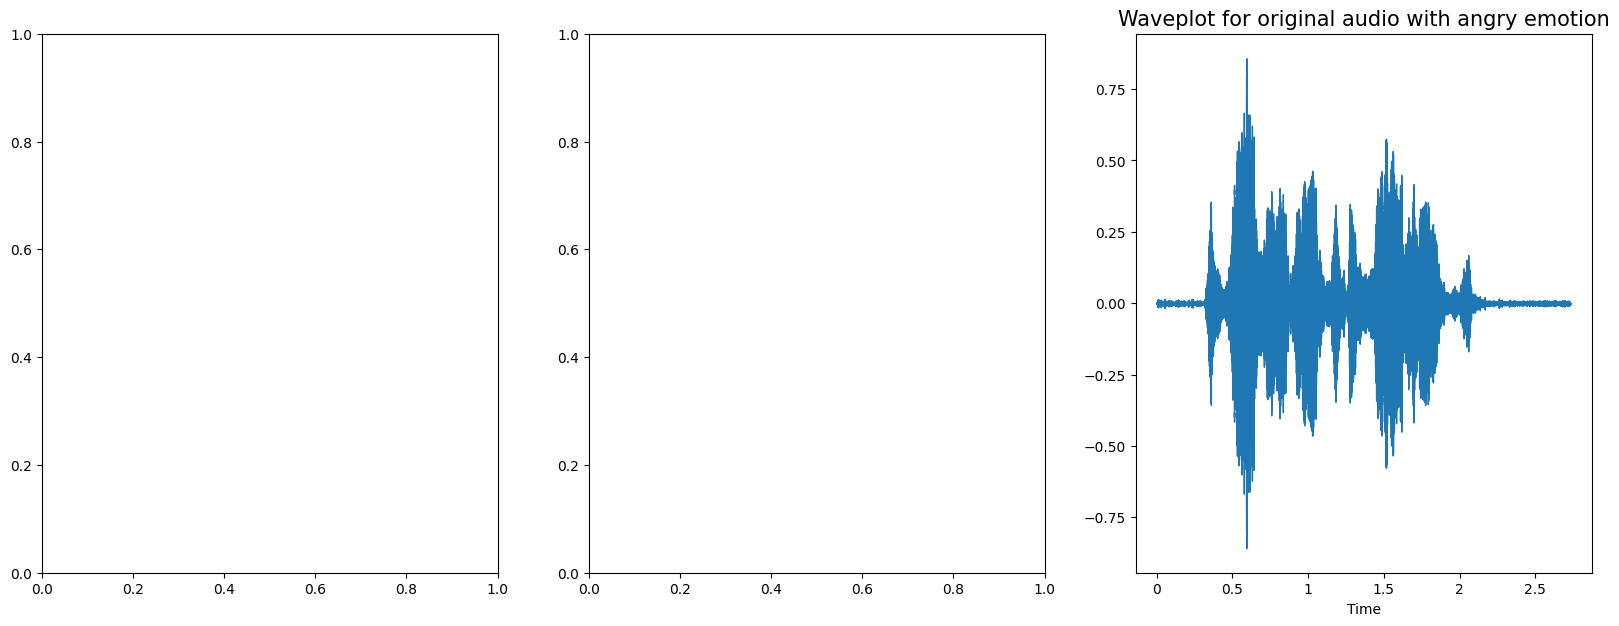

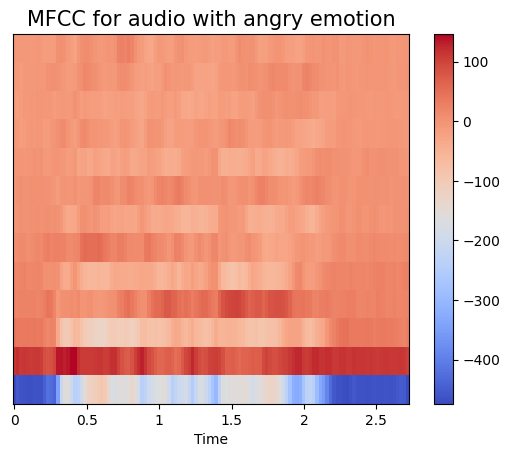

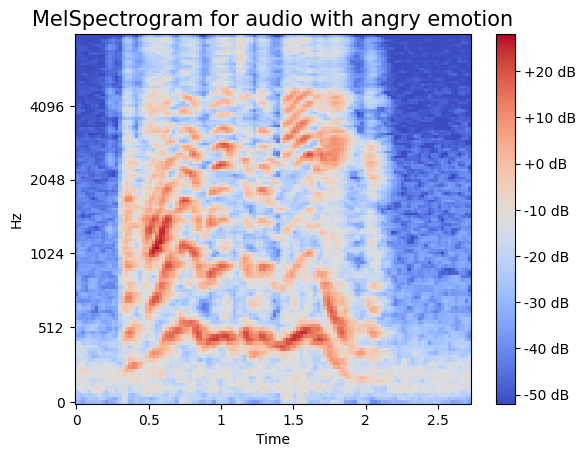

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

emotion = 'angry'
path = np.random.choice(crema_df.path[crema_df.target_emotion == emotion])
data, sampling_rate = librosa.load(path)

play_audio(path, sampling_rate)

create_waveplot(data, sampling_rate, 'original', emotion)
create_mfcc(data, sampling_rate, emotion)
create_melspectrogram(data, sampling_rate, emotion)

axes[1].set(title='Waveplot for audio with {} emotion'.format(emotion))
axes[1].set(title='MFCC for audio with {} emotion'.format(emotion))
axes[2].set(title='MelSpectrogram for audio with {} emotion'.format(emotion))

plt.show()


Audio file: 1091_MTI_NEU_XX.wav


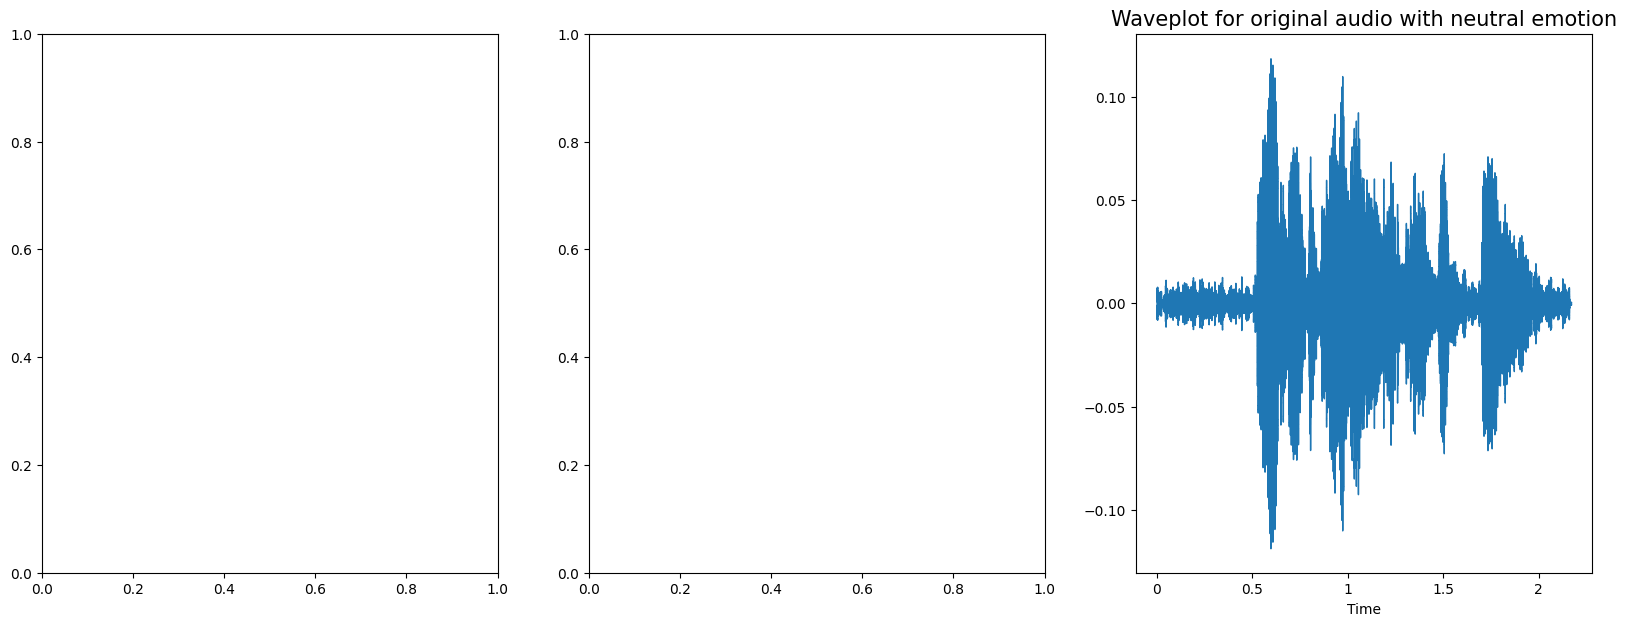

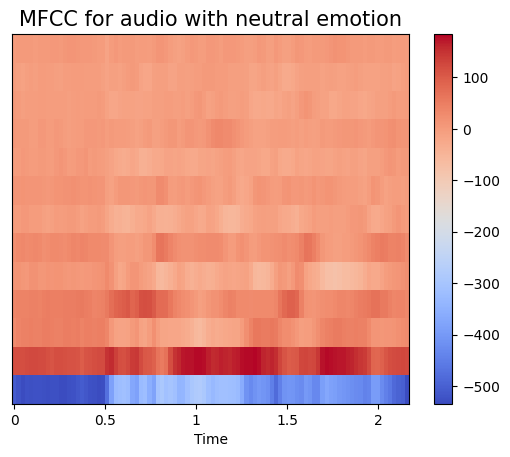

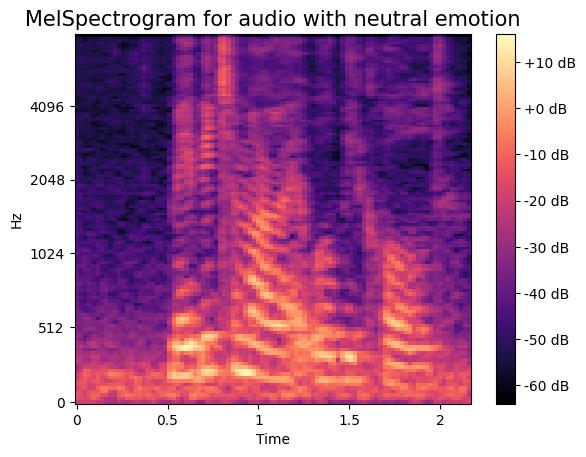

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

emotion = 'neutral'
path = np.random.choice(crema_df.path[crema_df.target_emotion == emotion])
data, sampling_rate = librosa.load(path)

play_audio(path, sampling_rate)

create_waveplot(data, sampling_rate, 'original', emotion)
create_mfcc(data, sampling_rate, emotion)
create_melspectrogram(data, sampling_rate, emotion)

axes[1].set(title='Waveplot for audio with {} emotion'.format(emotion))
axes[1].set(title='MFCC for audio with {} emotion'.format(emotion))
axes[2].set(title='MelSpectrogram for audio with {} emotion'.format(emotion))

plt.show()


Audio file: 1012_IEO_HAP_MD.wav


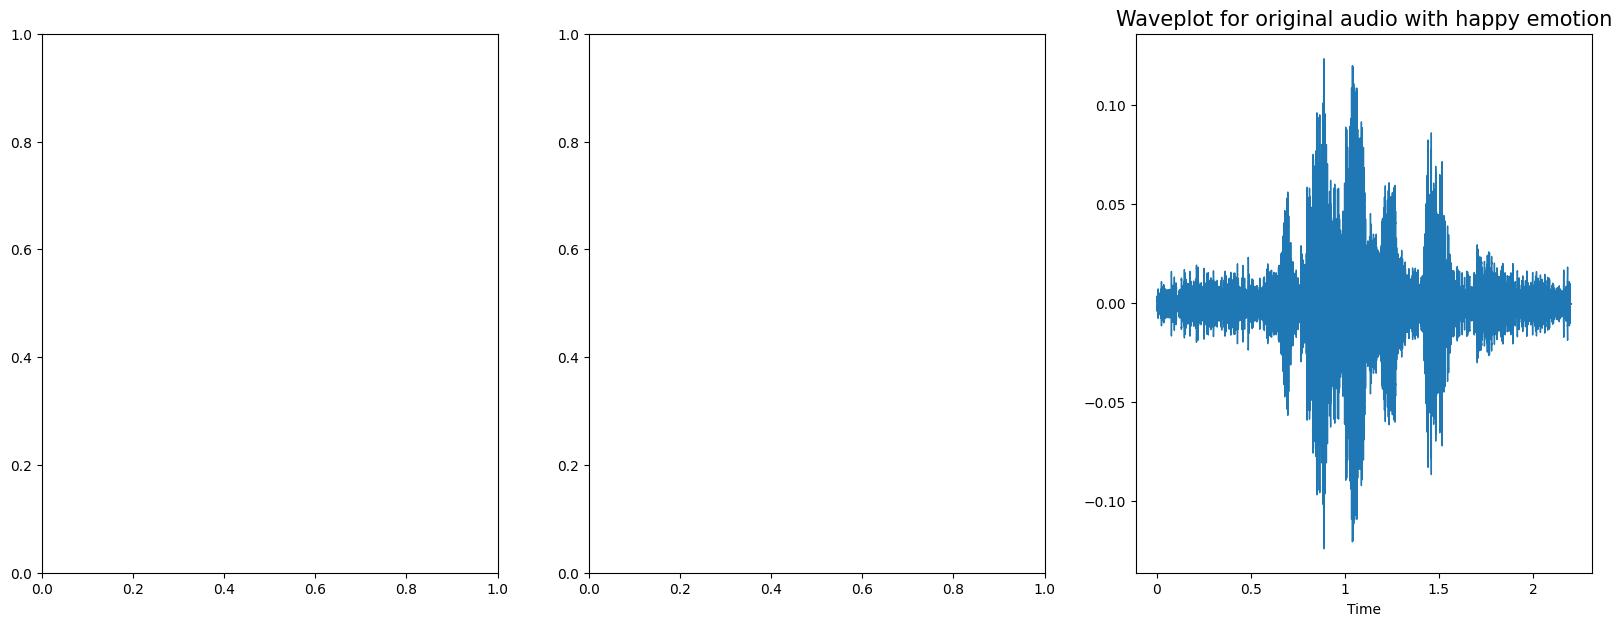

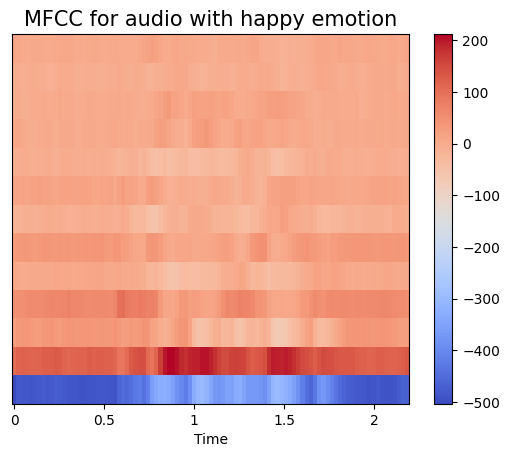

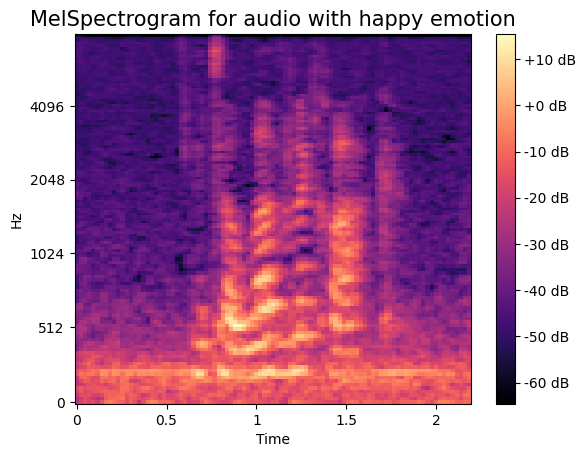

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

emotion = 'happy'
path = np.random.choice(crema_df.path[crema_df.target_emotion == emotion])
data, sampling_rate = librosa.load(path)

play_audio(path, sampling_rate)

create_waveplot(data, sampling_rate, 'original', emotion)
create_mfcc(data, sampling_rate, emotion)
create_melspectrogram(data, sampling_rate, emotion)

axes[1].set(title='Waveplot for audio with {} emotion'.format(emotion))
axes[1].set(title='MFCC for audio with {} emotion'.format(emotion))
axes[2].set(title='MelSpectrogram for audio with {} emotion'.format(emotion))

plt.show()


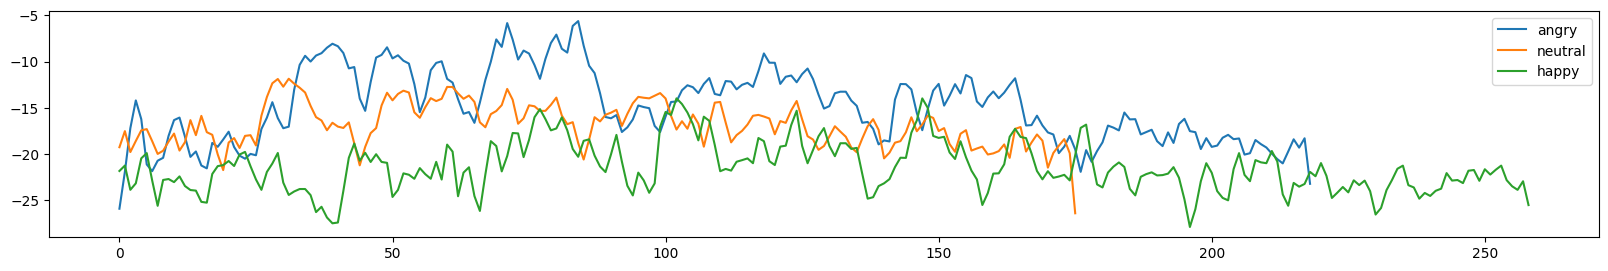

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)

for emotion in REQUIRED_EMOTIONS:
    path = np.random.choice(crema_df.path[crema_df.target_emotion == emotion])
    data, sample_rate = librosa.load(path,sr=22050*2)  
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    mfcc_feature = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)

# Plot the two audio waves together
    plt.plot(mfcc_feature, label=emotion)

plt.legend()
plt.show()

In [15]:
# NOISE
def noise(data, nf):
    return data + nf * np.random.randn(len(data))
# STRETCH
def stretch(data, stretch_f):
    return librosa.effects.time_stretch(data, rate = stretch_f)
# SHIFT
def shift(data, sampling_rate, shift_r):
    shift_distance = np.random.randint(shift_r[0], shift_r[1])
    return np.roll(data, shift_distance)
# PITCH
def pitch(data, sampling_rate, pitch_f):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_f)

In [16]:
SAMPLE_COUNT = crema_df.shape[0]

# Define the path to the CREMA-D dataset
sample = crema_df.iloc[np.random.randint(SAMPLE_COUNT)]
emotion = sample['target_emotion']
audio_path = sample['path']

# Define the noise parameters
NOISE_FACTOR = 0.05

# Define the stretching and shifting parameters
STRETCH_FACTOR = 0.8
SHIFT_RANGE = [-500, 500]

# Define the pitch parameters
PITCH_FACTOR = 2

data, sample_rate = librosa.load(audio_path)

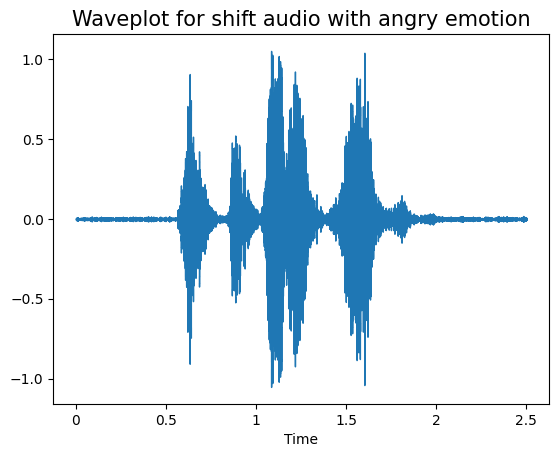

In [19]:
shift_data = shift(data, sample_rate, SHIFT_RANGE)
create_waveplot(shift_data, sample_rate, 'shift', emotion)
ipd.Audio(shift_data, rate = sample_rate)

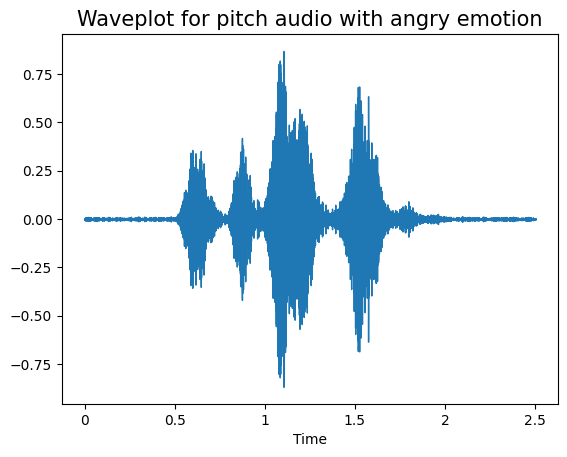

In [18]:
pitch_data = pitch(data, sample_rate, PITCH_FACTOR)
create_waveplot(pitch_data, sample_rate, 'pitch', emotion)
ipd.Audio(pitch_data, rate = sample_rate)

Feature Extraction

In [20]:
def extract_features(data, sample_rate):
    
    crema_feature_ar = np.array([])
    #zero crossing rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    #chromagram
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    #mfcc
    mfcc = np.abs(np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0))
    #root mean square
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #MelSpectrogram
    mel_S = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    #Spectral Centroid
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    #Spectral Bandwidth
    spec_bandwidth = np.abs(np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0))
    crema_feature_ar = np.hstack((crema_feature_ar, 
                                    chroma_stft,
                                    mfcc,
                                    rms,
                                    mel_S,
                                    zero_crossing_rate,
                                    spec_centroid,
                                    spec_bandwidth))

    return crema_feature_ar

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    crema_features_ar = extract_features(data, sample_rate=sample_rate)
    crema_data_features = np.array(crema_features_ar)
    
    # data with noise
    noise_data = noise(data, NOISE_FACTOR)
    res2 = extract_features(noise_data, sample_rate=sample_rate)
    crema_data_features = np.vstack((crema_data_features, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data, STRETCH_FACTOR)
    data_stretch_pitch = pitch(data, sample_rate, PITCH_FACTOR)
    res3 = extract_features(data_stretch_pitch, sample_rate=sample_rate)
    crema_data_features = np.vstack((crema_data_features, res3)) # stacking vertically
    
    return crema_data_features

In [21]:
X_crema_df = []
y_crema_df = []
for path, emotion in zip(crema_df.path, crema_df.target_emotion):
    feature = get_features(path)
    for f in feature:
        X_crema_df.append(f)
        y_crema_df.append(emotion)

X_crema_df = pd.DataFrame(X_crema_df)
y_crema_df = pd.DataFrame(y_crema_df)

In [61]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_crema_df, y_crema_df, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Create an MLP classifier and perform grid search with cross-validation
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Load the best hyperparameters and train a final model
best_params = grid_search.best_params_
best_mlp = MLPClassifier(**best_params, random_state=42)
best_mlp.fit(X_train, y_train)

# Test the final model
y_pred = best_mlp.predict(X_test)

# Evaluate the final model
print("Final model performance:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

Best hyperparameters:  {'activation': 'logistic', 'hidden_layer_sizes': (40,), 'learning_rate_init': 0.001}
Best score:  0.6996203763525424
Final model performance:
              precision    recall  f1-score   support

       angry       0.77      0.67      0.72       774
       happy       0.62      0.61      0.61       795
     neutral       0.70      0.82      0.76       665

    accuracy                           0.69      2234
   macro avg       0.70      0.70      0.70      2234
weighted avg       0.70      0.69      0.69      2234



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
audio_files = [os.path.join(root, f) for root, dirs, files in os.walk(crema_path) for f in files if f.endswith('.wav')]

data = []
labels = []

for audio_file in audio_files:
    y, sr = librosa.load(audio_file, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    emotion = os.path.basename(audio_file).split('_')[2]
    data.append(log_mel_spectrogram)
    labels.append(emotion)

max_length = max([spectrogram.shape[1] for spectrogram in data])

data_padded = []
for spectrogram in data:
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, max_length - spectrogram.shape[1])), 'constant')
    data_padded.append(padded_spectrogram)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_encoded, test_size=0.2, random_state=42)

# Get input shape for the models
input_shape = X_train[0].shape

# Create CNN-LSTM model
def create_cnn_lstm_model(input_shape):
    time_steps = 10
    input_shape_time_distributed = (input_shape[0] // time_steps, input_shape[1])

    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(time_steps, *input_shape_time_distributed, 1)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_lstm_model = create_cnn_lstm_model(input_shape)

time_steps = 10
input_shape_time_distributed = (input_shape[0] // time_steps, input_shape[1])




In [51]:


# Reshape input data for CNN-LSTM model
def reshape_for_cnn_lstm(data, time_steps):
    reshaped_data = []
    for sample in data:
        frames_per_step = sample.shape[0] // time_steps
        reshaped_sample = sample[:frames_per_step * time_steps].reshape(time_steps, frames_per_step, sample.shape[1])
        reshaped_data.append(reshaped_sample)
    return np.array(reshaped_data)

X_train_cnn_lstm = reshape_for_cnn_lstm(X_train, time_steps)
X_test_cnn_lstm = reshape_for_cnn_lstm(X_test, time_steps)

# Train the CNN-LSTM model
cnn_lstm_model.fit(X_train_cnn_lstm, np.array(y_train), epochs=20, batch_size=32, validation_data=(X_test_cnn_lstm, np.array(y_test)))

Epoch 1/20
193/193 [==============================] - 167s 838ms/step - loss: 1.6202 - accuracy: 0.3109 - val_loss: 1.5074 - val_accuracy: 0.3613
Epoch 2/20
193/193 [==============================] - 140s 726ms/step - loss: 1.4692 - accuracy: 0.3970 - val_loss: 1.4261 - val_accuracy: 0.4016
Epoch 3/20
193/193 [==============================] - 139s 720ms/step - loss: 1.4173 - accuracy: 0.4264 - val_loss: 1.4083 - val_accuracy: 0.4211
Epoch 4/20
193/193 [==============================] - 139s 719ms/step - loss: 1.3762 - accuracy: 0.4456 - val_loss: 1.3844 - val_accuracy: 0.4405
Epoch 5/20
193/193 [==============================] - 138s 713ms/step - loss: 1.3461 - accuracy: 0.4568 - val_loss: 1.3494 - val_accuracy: 0.4568
Epoch 6/20
193/193 [==============================] - 148s 766ms/step - loss: 1.3159 - accuracy: 0.4696 - val_loss: 1.3407 - val_accuracy: 0.4555
Epoch 7/20
193/193 [==============================] - 137s 712ms/step - loss: 1.2939 - accuracy: 0.4803 - val_loss: 1.3396 -

In [53]:
# Evaluate the CNN-LSTM model
cnn_lstm_test_loss, cnn_lstm_test_acc = cnn_lstm_model.evaluate(X_test_cnn_lstm, np.array(y_test), verbose=2)
print(f"CNN-LSTM Test Loss: {cnn_lstm_test_loss}, CNN-LSTM Test Accuracy: {cnn_lstm_test_acc}")

193/193 - 38s - loss: 0.6972 - accuracy: 0.7524 - 38s/epoch - 195ms/step
CNN-LSTM Test Loss: 0.697201669216156, CNN-LSTM Test Accuracy: 0.7523561716079712
